In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/niftyfutures-tick-by-tick-level-5-depth-data/data.csv


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


2025-04-28 12:25:05.858218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745843106.114123      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745843106.185632      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load your data
df = pd.read_csv('/kaggle/input/niftyfutures-tick-by-tick-level-5-depth-data/data.csv', parse_dates=['ist_datetime'])
df.set_index('ist_datetime', inplace=True)

# Calculate order book imbalance indicators
df['bid_value'] = (df['bid_price_1'] * df['bid_qty_1'] + 
                  df['bid_price_2'] * df['bid_qty_2'] + 
                  df['bid_price_3'] * df['bid_qty_3'] + 
                  df['bid_price_4'] * df['bid_qty_4'] + 
                  df['bid_price_5'] * df['bid_qty_5'])

df['ask_value'] = (df['ask_price_1'] * df['ask_qty_1'] + 
                  df['ask_price_2'] * df['ask_qty_2'] + 
                  df['ask_price_3'] * df['ask_qty_3'] + 
                  df['ask_price_4'] * df['ask_qty_4'] + 
                  df['ask_price_5'] * df['ask_qty_5'])

# Order book imbalance ratio
df['ob_imbalance'] = (df['bid_value'] - df['ask_value']) / (df['bid_value'] + df['ask_value'])

# Bid-ask spread
df['spread'] = df['ask_price_1'] - df['bid_price_1']

# Calculate market pressure
df['bid_pressure'] = df['totalbuyqty'] / (df['totalbuyqty'] + df['totalsellqty'])

# Volatility indicators
df['price_range'] = df['high'] - df['low']
df['return'] = df['close'].pct_change()
df['volatility'] = df['return'].rolling(window=10).std()

# Additional microstructure features
df['mid_price'] = (df['bid_price_1'] + df['ask_price_1']) / 2
df['weighted_mid_price'] = (df['bid_price_1'] * df['ask_qty_1'] + df['ask_price_1'] * df['bid_qty_1']) / (df['bid_qty_1'] + df['ask_qty_1'])

In [4]:
# Prepare features
features = ['ob_imbalance', 'spread', 'bid_pressure', 'volatility', 'volume', 
           'oi', 'oipercent', 'mid_price', 'weighted_mid_price']

# Function to prepare sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = np.sign(data[i + seq_length, 0] - data[i + seq_length - 1, 0])  # Direction prediction
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Normalize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features].values)

# Add price direction to the scaled data (for target)
price_direction = np.diff(df['close'].values)
price_direction = np.append(0, np.sign(price_direction))
scaled_data_with_target = np.column_stack((price_direction.reshape(-1, 1), scaled_data))

# Create sequences
seq_length = 30  # 30 time steps
X, y = create_sequences(scaled_data_with_target, seq_length)
y = tf.keras.utils.to_categorical(y + 1)  # Convert to one-hot encoding (-1,0,1 -> 0,1,2)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
# Add gradient clipping to prevent exploding gradients
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, len(features) + 1)),
    tf.keras.layers.LSTM(128, return_sequences=True, 
                        kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Add regularization
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, y_test)
)

I0000 00:00:1745843121.740636      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745843121.741339      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1745843127.747134      64 cuda_dnn.cc:529] Loaded cuDNN version 90300


259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3224 - loss: nan - val_accuracy: 0.2500 - val_loss: nan
Epoch 2/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2502 - loss: nan - val_accuracy: 0.2500 - val_loss: nan
Epoch 3/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2461 - loss: nan - val_accuracy: 0.2500 - val_loss: nan
Epoch 4/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2478 - loss: nan - val_accuracy: 0.2500 - val_loss: nan
Epoch 5/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2515 - loss: nan - val_accuracy: 0.2500 - val_loss: nan
Epoch 6/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2485 - loss: nan - val_accuracy: 0.2500 - val_loss: nan
Epoch 7/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2525 - loss: nan - val_accuracy: 0.2500 - val_loss: nan
Epoch 8/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2526 - loss: nan - val_accuracy: 0.2500 - val_loss: nan
Epoch 9/50
259/259 ━━━━━━━━━━━━━━━

In [5]:
def create_order_book_visualization(df):
    fig = make_subplots(rows=3, cols=1, 
                        shared_xaxes=True,
                        vertical_spacing=0.05,
                        subplot_titles=('Price & Trades', 'Order Book Imbalance', 'Volume & OI'),
                        row_heights=[0.5, 0.25, 0.25])
    
    # Price chart with buy/sell signals
    fig.add_trace(
        go.Candlestick(
            x=df.index,
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close'],
            name='Price'
        ),
        row=1, col=1
    )
    
    # Add buy signals
    buy_signals = df[df['signal'] == 1]
    fig.add_trace(
        go.Scatter(
            x=buy_signals.index,
            y=buy_signals['low'] * 0.999,  # Slightly below the candle
            mode='markers',
            marker=dict(color='green', size=10, symbol='triangle-up'),
            name='Buy Signal'
        ),
        row=1, col=1
    )
    
    # Add sell signals
    sell_signals = df[df['signal'] == -1]
    fig.add_trace(
        go.Scatter(
            x=sell_signals.index,
            y=sell_signals['high'] * 1.001,  # Slightly above the candle
            mode='markers',
            marker=dict(color='red', size=10, symbol='triangle-down'),
            name='Sell Signal'
        ),
        row=1, col=1
    )
    
    # Order book imbalance
    colors = ['red' if val < 0 else 'green' for val in df['ob_imbalance']]
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=df['ob_imbalance'],
            marker_color=colors,
            name='Order Book Imbalance'
        ),
        row=2, col=1
    )
    
    # Add threshold lines
    fig.add_shape(
        type="line", line=dict(dash='dash'),
        x0=df.index[0], y0=0.2, x1=df.index[-1], y1=0.2,
        line_color="green", row=2, col=1
    )
    fig.add_shape(
        type="line", line=dict(dash='dash'),
        x0=df.index[0], y0=-0.2, x1=df.index[-1], y1=-0.2,
        line_color="red", row=2, col=1
    )
    
    # Volume and Open Interest
    fig.add_trace(
        go.Bar(x=df.index, y=df['volume'], name='Volume', marker_color='lightblue'),
        row=3, col=1
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df['oi'], name='Open Interest', line=dict(color='purple')),
        row=3, col=1
    )
    
    # Layout adjustments
    fig.update_layout(
        title='Order Book Analysis with AI Trading Signals',
        height=900,
        width=1200,
        xaxis_rangeslider_visible=False
    )
    
    return fig

In [6]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm  # import tqdm

def predict_with_model(model, df, features, seq_length):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[features].values)

    predictions = []

    # Use tqdm to show progress
    for i in tqdm(range(seq_length, len(df)), desc="Predicting"):
        sequence = scaled_data[i-seq_length:i]
        sequence = sequence.reshape(1, seq_length, len(features))
        
        pred = model.predict(sequence, verbose=0)
        pred_class = np.argmax(pred) - 1  # 0,1,2 to -1,0,1
        predictions.append(pred_class)

    padding = [np.nan] * seq_length
    return padding + predictions


In [8]:
# 1. Predict
df['prediction'] = predict_with_model(model, df, features, seq_length)

# 2. Signal Generation
df['signal'] = 0
df.loc[(df['prediction'] == 1) & (df['ob_imbalance'] > 0.2), 'signal'] = 1
df.loc[(df['prediction'] == -1) & (df['ob_imbalance'] < -0.2), 'signal'] = -1

# 3. Strategy returns
df['position'] = df['signal'].shift(1).fillna(0)
df['returns'] = df['close'].pct_change()
df['strategy_returns'] = df['position'] * df['returns']
df['cumulative_returns'] = (1 + df['strategy_returns']).cumprod()
df['buy_hold_returns'] = (1 + df['returns']).cumprod()


Predicting: 100%|██████████| 20700/20700 [20:07<00:00, 17.14it/s]


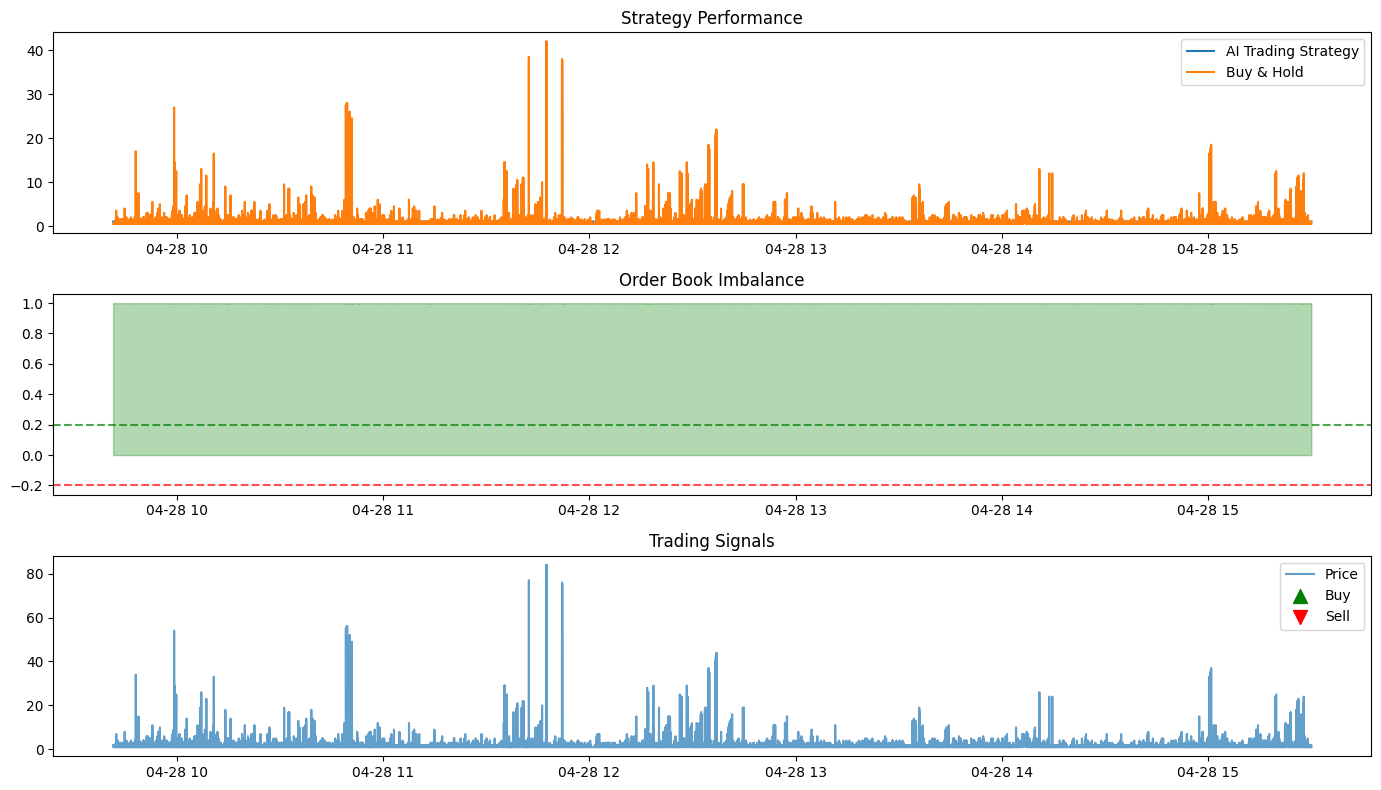

In [9]:
# For backtesting visualization
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.title('Strategy Performance')
plt.plot(df.index, df['cumulative_returns'], label='AI Trading Strategy')
plt.plot(df.index, df['buy_hold_returns'], label='Buy & Hold')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Order Book Imbalance')
plt.fill_between(df.index, df['ob_imbalance'], where=df['ob_imbalance']>0, color='green', alpha=0.3)
plt.fill_between(df.index, df['ob_imbalance'], where=df['ob_imbalance']<0, color='red', alpha=0.3)
plt.axhline(y=0.2, color='g', linestyle='--', alpha=0.7)
plt.axhline(y=-0.2, color='r', linestyle='--', alpha=0.7)

plt.subplot(3, 1, 3)
plt.title('Trading Signals')
plt.plot(df.index, df['close'], alpha=0.7, label='Price')
buy_signals = df[df['signal'] == 1]
sell_signals = df[df['signal'] == -1]
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', s=100, label='Sell')
plt.legend()

plt.tight_layout()
plt.show()

# For interactive visualization
interactive_plot = create_order_book_visualization(df)
interactive_plot.show()